<a href="https://colab.research.google.com/github/JaimeRoss/Prediction-of-Product-Sales/blob/main/prediction_of_product_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author: Jaime Ross

## Project Overview
The first project will be a sales prediction for food items sold at various stores. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales

#Mounting Drive

In [26]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# imports required
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load and Inspect Data

In [28]:
# loading and inspecting data

URL = "/content/drive/MyDrive/Student folder for data science bootcamp/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
df = pd.read_csv(URL)

In [29]:
#inspecting first 5 rows
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [30]:
# Using .info() to view summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Clean Data

In [31]:
# overview of questions to be addressed:
#-----------------------------------------
# 1) How many rows and columns?
# 2) What are the datatypes of each variable?
# 3) Are there duplicates? If so, drop any duplicates.
# 4) Identify missing values.
# 5) Address the missing values by using a placeholder value.
# 6) Confirm that there are no missing values after addressing them.
# 7) Find and fix any inconsistent categories of data (for example: fix cat, Cat, and cats so that they are consistent).
# 8) For any numerical columns, obtain the summary statistics of each (min, max, mean).
#-----------------------------------------

In [32]:
# 1) How many rows and columns?
df.shape

(8523, 12)

## Answer:
There are 8523 rows and 12 columns of data.

In [33]:
# 2) What are the datatypes of each variable?
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Answer:
In this dataset there are 3 data types namely:
- object
- float64
- int64

In [34]:
# 3) Are there duplicates? If so, drop any duplicates.

# Checking for duplicated data
df.duplicated().sum()

0

## Answer:
There are no duplicate entries in this dataset.

In [35]:
# 4) Identify missing values.
Missing_val = df.isna().sum()
Missing_val

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [36]:
# Calculating the percentage of missing values for each column.
Missing_val / len(df)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

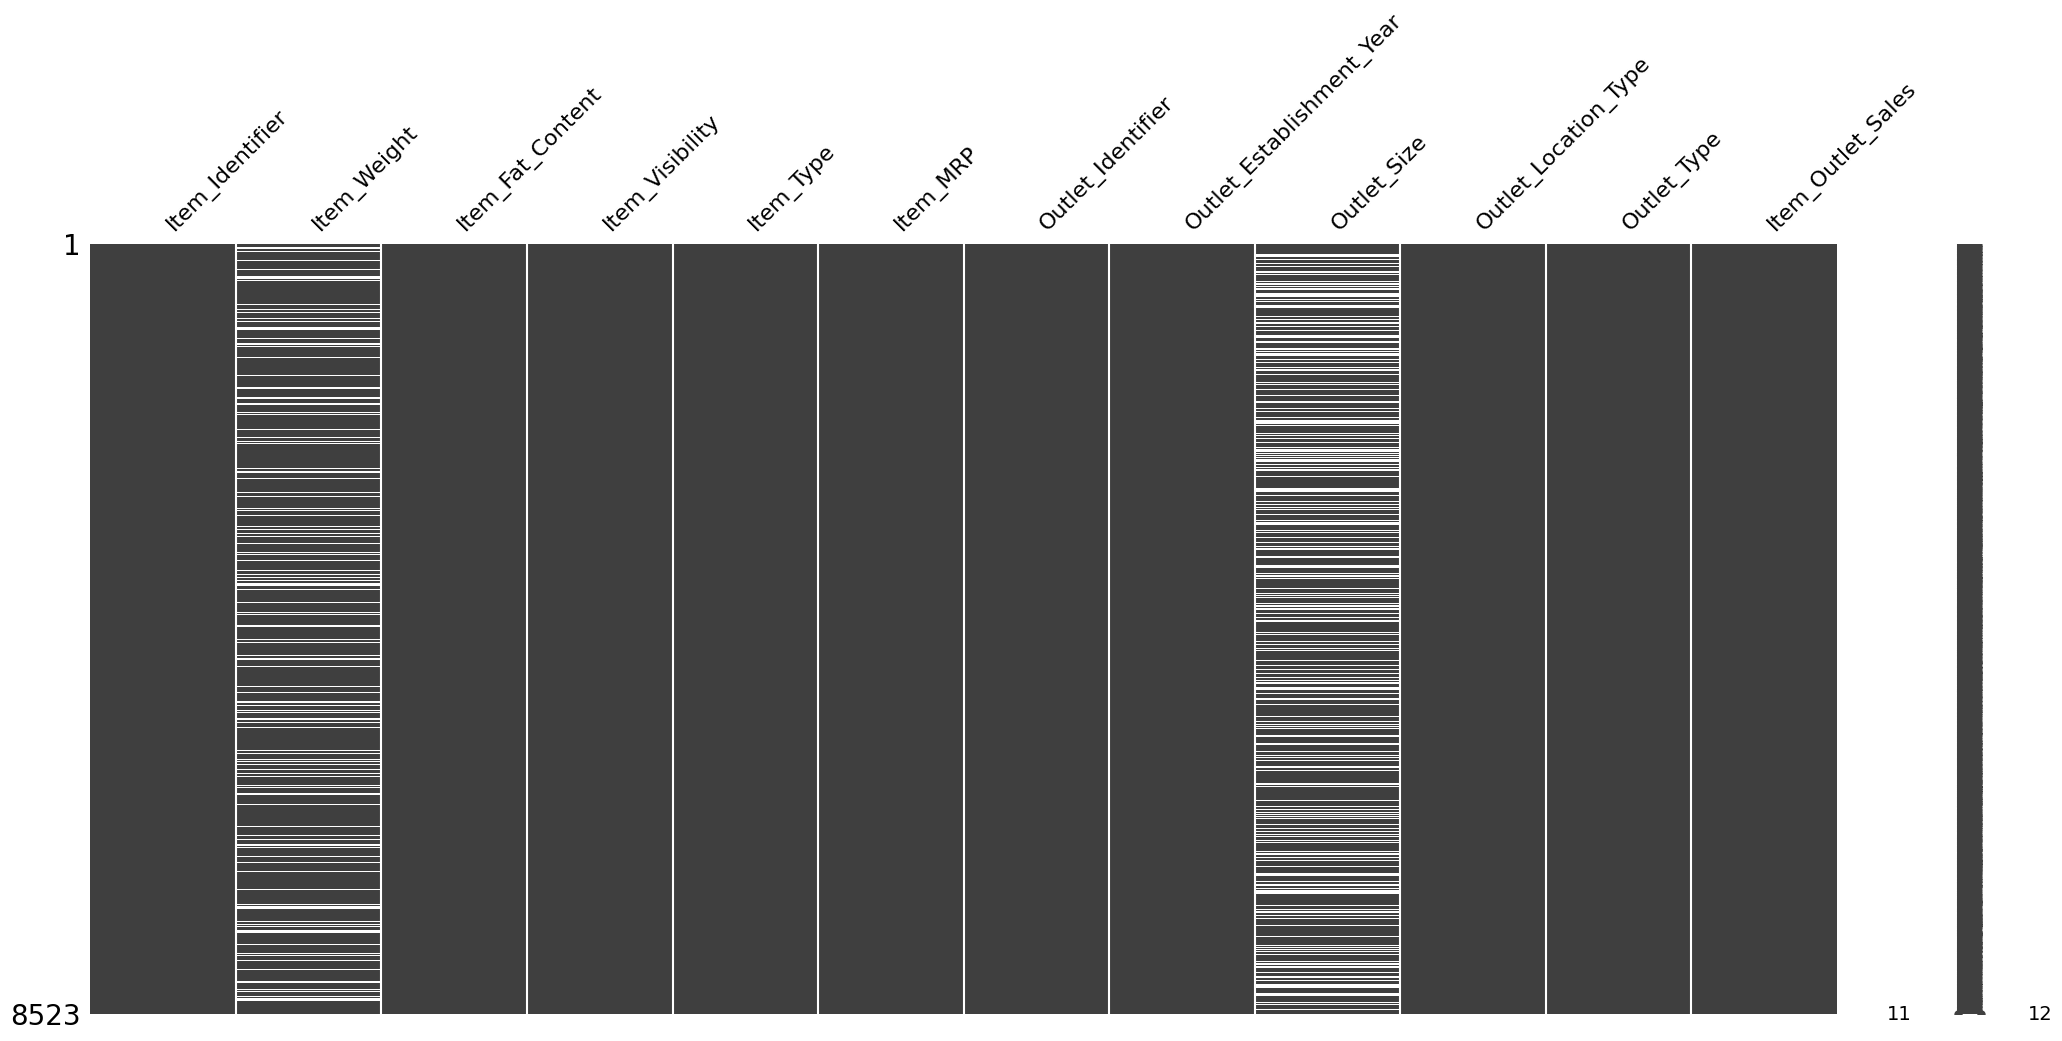

In [37]:
# Getting a visual representation of the missing data using missingno.
msno.matrix(df);

## Answer:
There are missing values in the Item_Weight and Outlet_Size columns.

In [38]:
# 5) Address the missing values by using a placeholder value.

# Creating a list of the numerical columns
num_col = df.select_dtypes("number").columns
num_col

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [39]:
# Placeholder for missing data in numerical columns
numerical_placeholder = -1

# Filling in missing values with a placeholder(-1)
df[num_col] = df[num_col].fillna(numerical_placeholder)

In [40]:
# Creating a list of the categorial columns
cat_col = df.select_dtypes("object").columns
cat_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [41]:
# Placeholder for missing data in categorial columns
categorial_placeholder = "MISSING_DATA"

# Filling in missing values with a placeholder(MISSING_DATA)
df[cat_col] = df[cat_col].fillna(categorial_placeholder)

## Answer:

The missing values have been replaced by placeholders (-1) for numerical columns and (MISSING_DATA) for categorial columns.

In [42]:
# 6) Confirm that there are no missing values after addressing them.
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

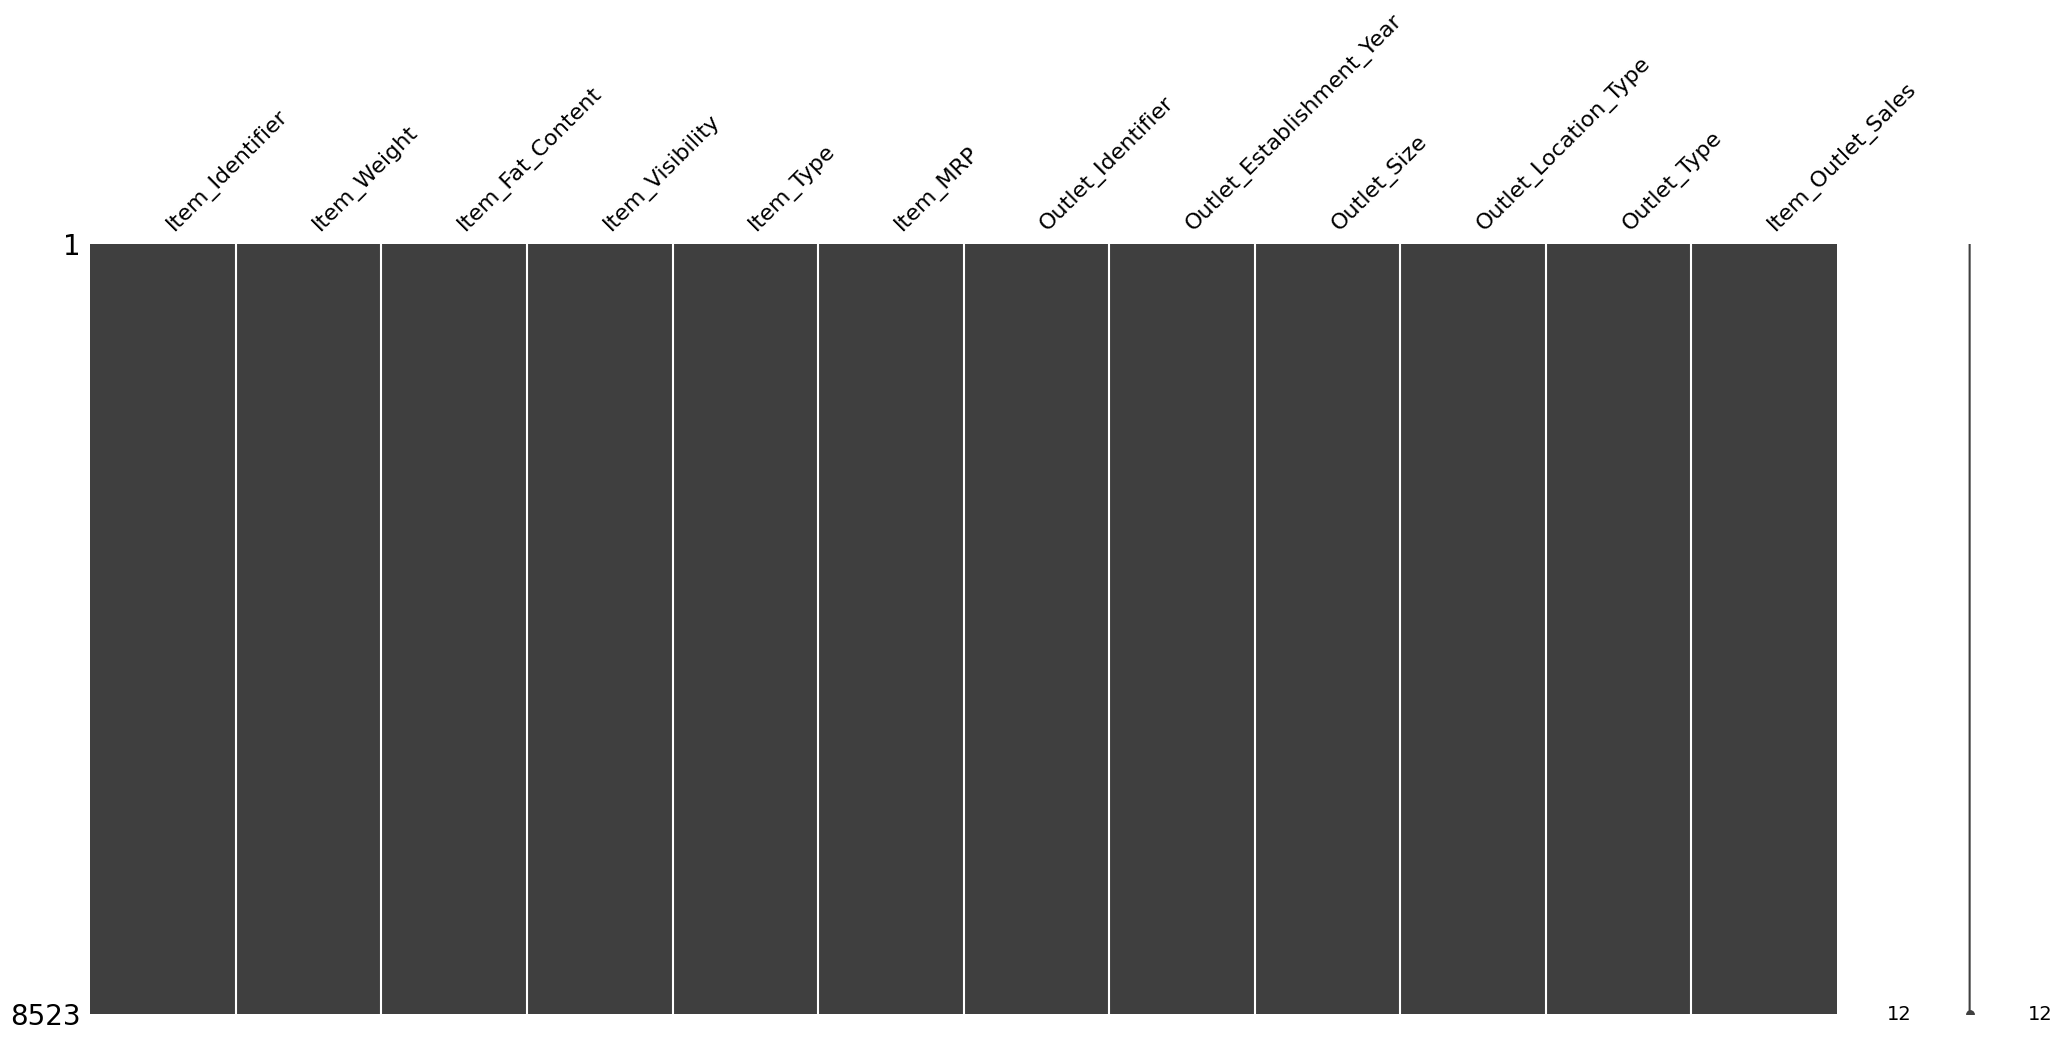

In [43]:
# Using missingno to confirm that there are no more missing values in the dataset.
msno.matrix(df);

## Answer:
There are no more missing values in the dataset.

In [44]:
# 7) Find and fix any inconsistent categories of data (for example: fix cat, Cat, and cats so that they are consistent).

for column in cat_col:
    # print the value counts for the column
    print(f"Value Counts for {column}")
    print(df[column].value_counts())
  # Print an empty line for readability
    print("\n")

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


In [45]:
# viewing inconsistency in Item_Fat_Content column
df["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

## Answer:

There is a categorial column that has inconsistent data entries (Item_Fat_Content), the values should be either Low Fat or Regular

In [46]:
# Fixing values in Item_Fat_Content and checking to see if it has been corrected
df["Item_Fat_Content"] = df["Item_Fat_Content"].replace(["LF", "reg","low fat"] , ["Low Fat", "Regular", "Low Fat"])
df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [47]:
# 8) For any numerical columns, obtain the summary statistics of each (min, max, mean).
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,10.48,0.07,140.99,1997.83,2181.29
std,6.72,0.05,62.28,8.37,1706.50
min,-1.00,0.00,31.29,1985.00,33.29
25%,6.65,0.03,93.83,1987.00,834.25
50%,11.00,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


In [48]:
# Finding Min, Max, Mean
statistics = df.describe()
statistics.loc[["min","max","mean"]]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,-1.000000,0.000000,31.290000,1985.000000,33.290000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800
mean,10.478936,0.066132,140.992782,1997.831867,2181.288914


## Answer:
In our dataset we have a min() value of -1 for our Item_weight, this value is not our minimum value as we had missing values for our numerical column that were replaced with our placeholder(-1). We have a max() value of of 21.35 for our Item_weight. To fix this error in our min() value, we could replace our placeholder value with the average weight to obtain an accurate measure for our min() value.

In [49]:
# fixing min() value for our Item_weight column

mean_weight = df["Item_Weight"].mean()
df["Item_Weight"] = df["Item_Weight"].replace(-1 , mean_weight)
New_Stats = df.describe()
New_Stats.loc[["min","max","mean"]]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,4.555000,0.000000,31.290000,1985.000000,33.290000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800
mean,12.449332,0.066132,140.992782,1997.831867,2181.288914


In [50]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.449332,0.066132,140.992782,1997.831867,2181.288914
std,4.320272,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,11.000000,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Answer:
We have now fixed the error in our data and have a more acurate value of 4.55 for our min() Item_Weight value.

## Exploratory Data Analysis


#Heatmap

In [57]:
# Getting correlation data
corr = df.corr()
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.030957,0.026032,0.136759,-0.005451
Item_Visibility,-0.030957,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.026032,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,0.136759,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,-0.005451,-0.128625,0.567574,-0.049135,1.000000


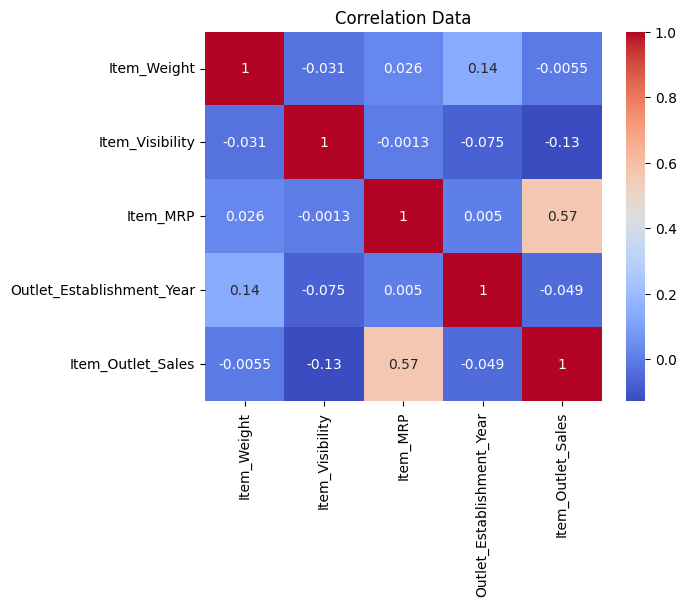

In [60]:
# Creating the heatmap
ax = sns.heatmap(corr, cmap="coolwarm", annot = True)
ax.set_title("Correlation Data");

Looking at the above graph we can see that there is a moderate positive correlation of 0.57 between the Item_MRP and Item_Outlet_Sales features.

#Countplots for categorial columns

In [65]:
# viewing categorial columns
df[cat_col]

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,MISSING_DATA,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,MISSING_DATA,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


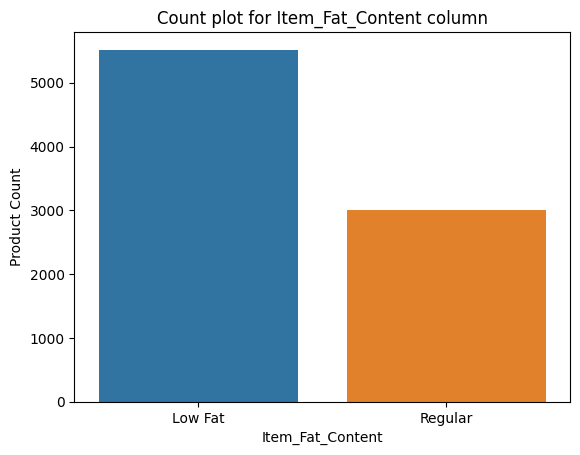

In [70]:
# Creating a countplot for the Item_Fat_content feature
ax = sns.countplot(df, x="Item_Fat_Content")
ax.set_title("Count plot for Item_Fat_Content column")
ax.set_ylabel("Product Count");

Looking at the above graph we can see that there is a higher product count for Low Fat Items

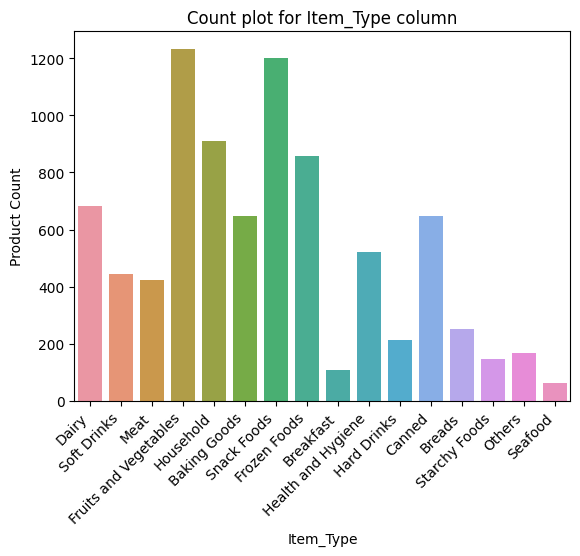

In [93]:
# Creating a countplot for the Item_Type feature
ax = sns.countplot(df, x="Item_Type")
ax.set_title("Count plot for Item_Type column")
ax.set_ylabel("Product Count");
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

The items with the highest product counts are fruits and vegetables, and snack foods. The items with the lowest product count are seafood products and breakfast products.

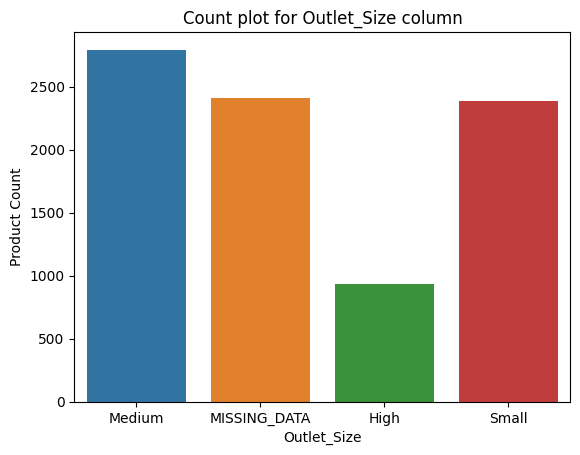

In [85]:
# Creating a countplot for the Outlet_Size feature
ax = sns.countplot(df, x="Outlet_Size")
ax.set_title("Count plot for Outlet_Size column")
ax.set_ylabel("Product Count");

Majority of the stores from the data that is available is medium in size. There are over 2000 entries of missing data in this dataset.

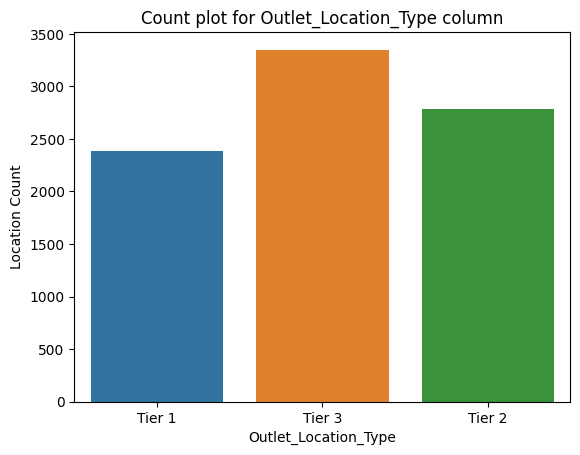

In [94]:
# Creating a countplot for the Outlet_Location_Type feature
ax = sns.countplot(df, x="Outlet_Location_Type")
ax.set_title("Count plot for Outlet_Location_Type column")
ax.set_ylabel("Location Count");

The Tier 3 location has the highest count.

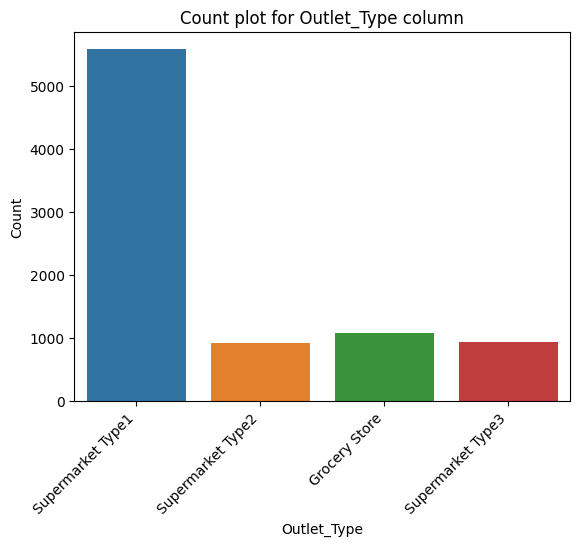

In [96]:
# Creating a countplot for the Outlet_Type feature
ax = sns.countplot(df, x="Outlet_Type")
ax.set_title("Count plot for Outlet_Type column")
ax.set_ylabel("Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Supermarket Type 1 is the most popular Outlet type.

#Histograms for numerical features:

In [97]:
# Viewing our numerical columns
df[num_col]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.300,0.016047,249.8092,1999,3735.1380
1,5.920,0.019278,48.2692,2009,443.4228
2,17.500,0.016760,141.6180,1999,2097.2700
3,19.200,0.000000,182.0950,1998,732.3800
4,8.930,0.000000,53.8614,1987,994.7052
...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1987,2778.3834
8519,8.380,0.046982,108.1570,2002,549.2850
8520,10.600,0.035186,85.1224,2004,1193.1136
8521,7.210,0.145221,103.1332,2009,1845.5976


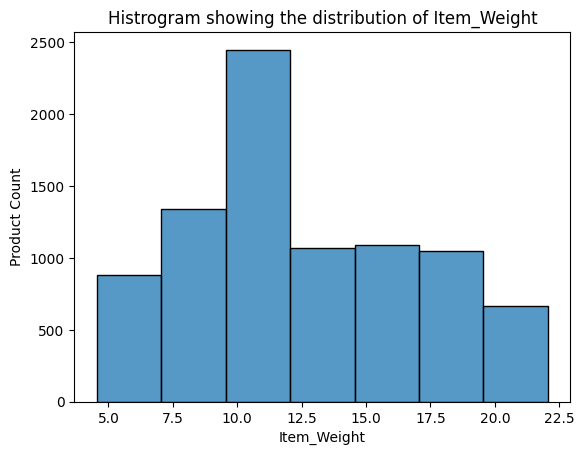

In [114]:
# Creating a histogram for the Item_Weight column
ax = sns.histplot(df, x="Item_Weight", bins="auto", binwidth=2.5)
ax.set_title("Histrogram showing the distribution of Item_Weight")
ax.set_ylabel("Product Count");

The Items with the highest count fall in between the weight category of 10.0-12.0

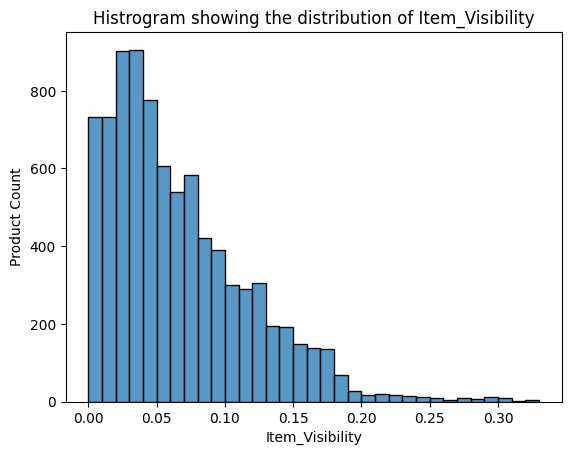

In [111]:
# Creating a histogram for the Item_Visibility column
ax = sns.histplot(df, x="Item_Visibility", bins="auto", binwidth=0.01)
ax.set_title("Histrogram showing the distribution of Item_Visibility")
ax.set_ylabel("Product Count");

The items with the highest visibility are between 0.3-0.4

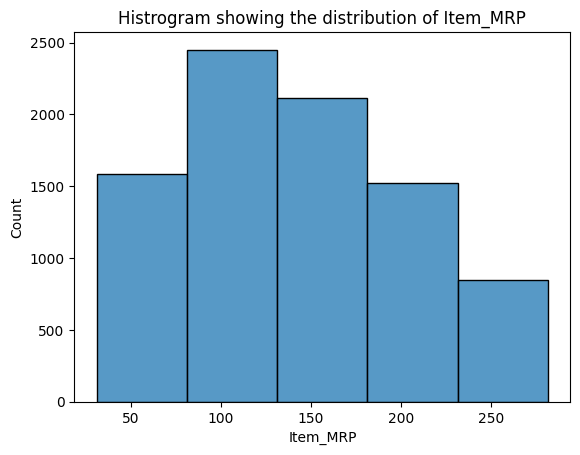

In [117]:
# Creating a histogram for the Item_MRP column
ax = sns.histplot(df, x="Item_MRP", bins="auto", binwidth=50)
ax.set_title("Histrogram showing the distribution of Item_MRP")
ax.set_ylabel("Count");

The most frequent Item_MRP falls between 85 and 135.

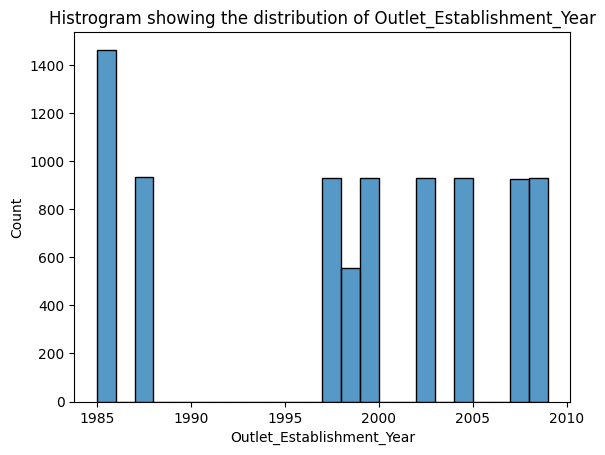

In [125]:
# Creating a histogram for the Outlet_Establishment_Year column
ax = sns.histplot(df, x="Outlet_Establishment_Year", bins="20", binwidth=1)
ax.set_title("Histrogram showing the distribution of Outlet_Establishment_Year")
ax.set_ylabel("Count");

Majority of stores were etablished in 1985. There were no stores established between 1990 and 1995.

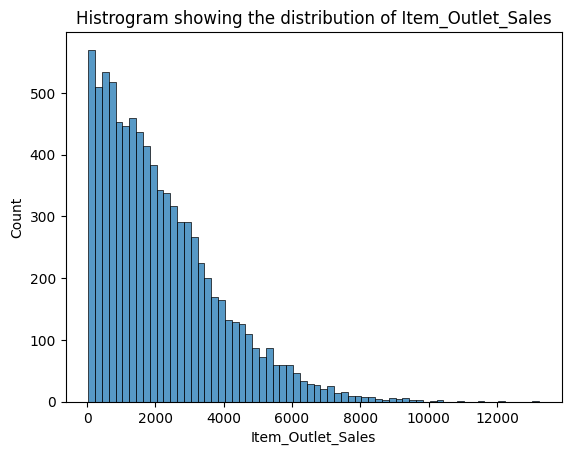

In [128]:
# Creating a histogram for the Item_Outlet_Sales column
ax = sns.histplot(df, x="Item_Outlet_Sales", bins="20", binwidth=200)
ax.set_title("Histrogram showing the distribution of Item_Outlet_Sales")
ax.set_ylabel("Count");

As the sales price increases, the number of items sold decreases. The highest number of sales occur between the price range of 0-2000.

#Boxplots for numerical columns:

In [139]:
# Getting summary of statistics for numerical columns
df[num_col].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.45,0.07,140.99,1997.83,2181.29
std,4.32,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,9.31,0.03,93.83,1987.00,834.25
50%,11.00,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


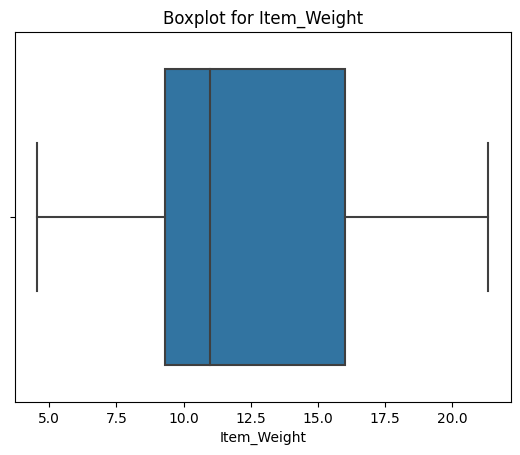

In [134]:
ax = sns.boxplot(df, x="Item_Weight")
ax.set_title("Boxplot for Item_Weight");

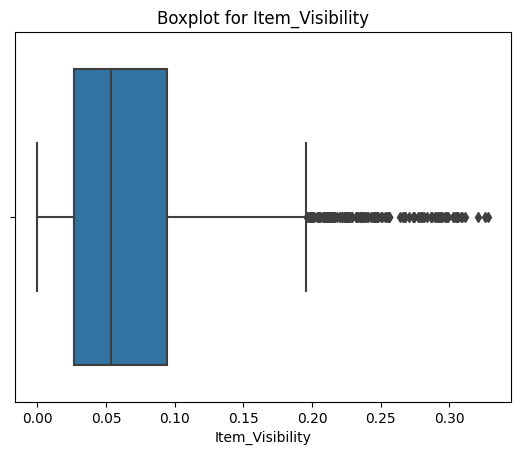

In [135]:
ax = sns.boxplot(df, x="Item_Visibility")
ax.set_title("Boxplot for Item_Visibility");

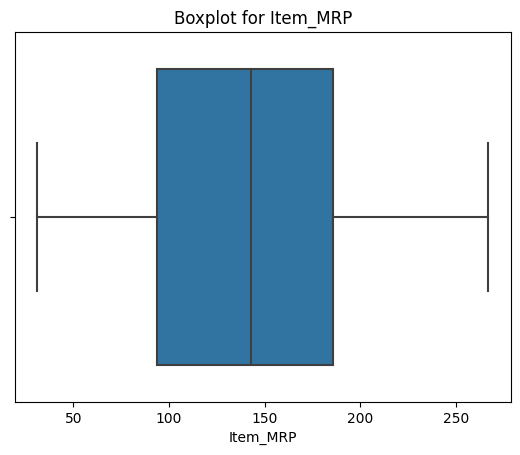

In [136]:
ax = sns.boxplot(df, x="Item_MRP")
ax.set_title("Boxplot for Item_MRP");

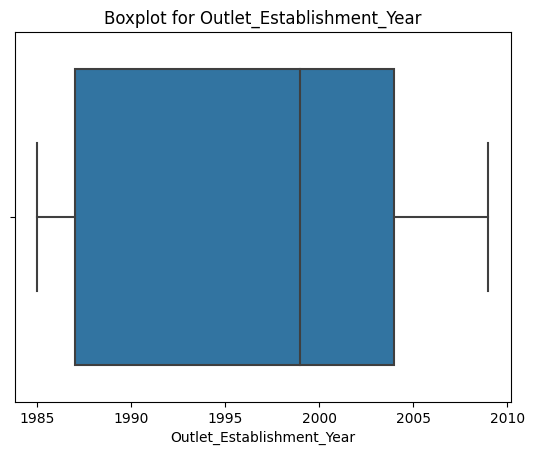

In [137]:
ax = sns.boxplot(df, x="Outlet_Establishment_Year")
ax.set_title("Boxplot for Outlet_Establishment_Year");

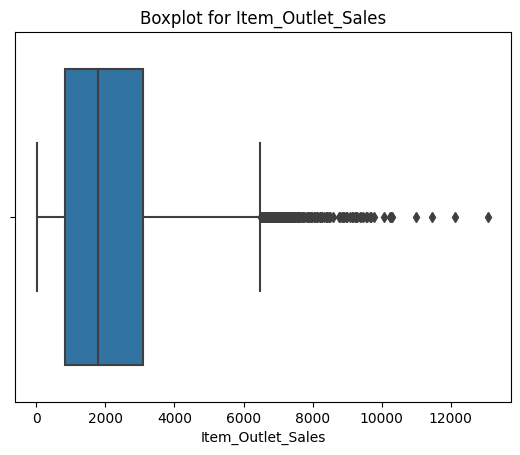

In [138]:
ax = sns.boxplot(df, x="Item_Outlet_Sales")
ax.set_title("Boxplot for Item_Outlet_Sales");

## Explanatory Data Analysis